## load dataset

In [3]:
# # Install necessary packages
# !pip install kaggle gdown

# Download Kaggle API token from Google Drive
gdrive_url = 'https://drive.google.com/uc?id=1P6t7O8vOjmQi3rMX0KQlgO6BT0fk2dI-'

# Configure the Kaggle API
import os
from pathlib import Path

import gdown
if not os.path.exists('kaggle.json'):
    gdown.download(gdrive_url, 'kaggle.json', quiet=False)

kaggle_dir = Path.home() / '.kaggle'
kaggle_token_path = kaggle_dir / 'kaggle.json'

if not kaggle_token_path.exists():
    # Create the .kaggle directory if it does not exist
    kaggle_dir.mkdir(parents=True, exist_ok=True)

    # Move the kaggle.json to ~/.kaggle/
    os.rename('kaggle.json', kaggle_token_path)

    # Set the permissions to read and write for the user only
    kaggle_token_path.chmod(0o600)

dataset_path = 'A_Z Handwritten Data.csv'

if not os.path.exists(dataset_path):
    # Download the dataset from Kaggle
    kaggle_remote_path = 'sachinpatel21/az-handwritten-alphabets-in-csv-format'
    !kaggle datasets download -d {kaggle_remote_path} --unzip

import pandas as pd
data = pd.read_csv(dataset_path)
display(data.head())
print('data shape:', data.shape)

OSError: [WinError 17] The system cannot move the file to a different disk drive: 'kaggle.json' -> 'C:\\Users\\KYLEONEIL\\.kaggle\\kaggle.json'

In [9]:
# Define the kana characters and their corresponding labels
letters = [chr(i) for i in range(65, 91)]
print(letters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## perform CNN

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt # plotting
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [11]:
num_samples = 372450
num_classes = 26  # Number of letters in the alphabet

# data.insert(0, 'alphabet', np.random.randint(0, num_classes, size=num_samples))

# Add column names
columns = ['alphabet'] + [f'pixel_{i}' for i in range(1, 785)]
data.columns = columns
data.columns

Index(['alphabet', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5',
       'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9',
       ...
       'pixel_775', 'pixel_776', 'pixel_777', 'pixel_778', 'pixel_779',
       'pixel_780', 'pixel_781', 'pixel_782', 'pixel_783', 'pixel_784'],
      dtype='object', length=785)

In [12]:
from tensorflow.keras.utils import to_categorical

# X = np.random.randint(0, 256, size=(num_samples, 784))
# y = np.random.randint(0, num_classes, size=(num_samples,))
# X = X.reshape(-1, 28, 28, 1)
# X = X / 255.0
# y = to_categorical(y, num_classes)
y = data['alphabet']
X = data.drop('alphabet', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape,

((260715, 784), (111735, 784))

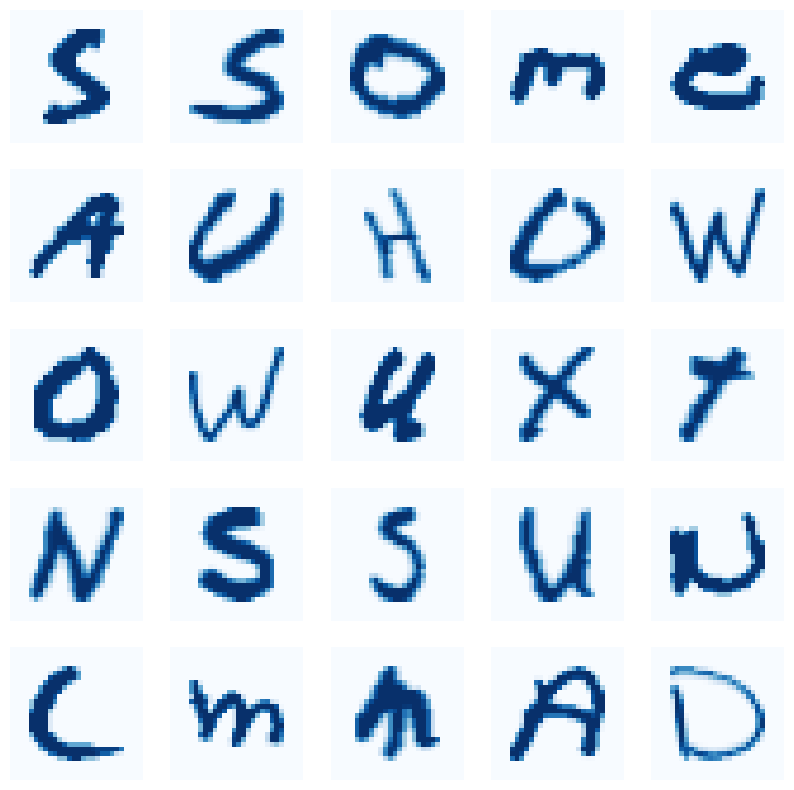

In [13]:
import numpy as np

random_indices = np.random.choice(range(len(X)), size=25, replace=False)
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for i,ax in enumerate(axes.ravel()):
    ax.imshow(X.iloc[random_indices[i]].values.reshape(28, 28), cmap='Blues')
    ax.axis('off')
plt.show()

In [15]:
# model with 1d convolution

from tensorflow.keras import layers

cnn = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((X_train.shape[1], 1)),  # Reshape to (784, 1)
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
], name='one_dimensional_cnn')
cnn.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
cnn.summary()

# Train the model
history_cnn = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
history_cnn.history['name'] = cnn.name

# Evaluate the model
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

c:\Users\duterte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "one_dimensional_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 784, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 782, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 391, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 389, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 194, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,589,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,599,066 (6.10 MB)

 Trainable params: 1,599,066 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\duterte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8148/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5176 - loss: 2.0611

c:\Users\duterte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8148/8148 ━━━━━━━━━━━━━━━━━━━━ 178s 22ms/step - accuracy: 0.5176 - loss: 2.0610 - val_accuracy: 0.9284 - val_loss: 0.2693
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9284 - loss: 0.2693
Test Accuracy: 92.84%


In [16]:
# multilayer perceptron without convolution

mlp = tf.keras.models.Sequential(name='multilayer_perceptron')
mlp.add(layers.InputLayer(shape=(X_train.shape[1],)))
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))
mlp.add(layers.Dense(26, activation='linear'))
mlp.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
mlp.summary()

# Evaluate untrained model
test_loss, test_accuracy = mlp.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Model: "multilayer_perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

3492/3492 ━━━━━━━━━━━━━━━━━━━━ 3s 679us/step - accuracy: 0.0265 - loss: 160.3898
Test Accuracy: 2.61%


In [17]:
history_mlp = mlp.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
history_mlp.history['name'] = cnn.name

# Evaluate the model after training
test_loss, test_accuracy = mlp.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8148/8148 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4496 - loss: 9.2166 - val_accuracy: 0.7434 - val_loss: 1.0170
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.7432 - loss: 1.0168
Test Accuracy: 74.34%


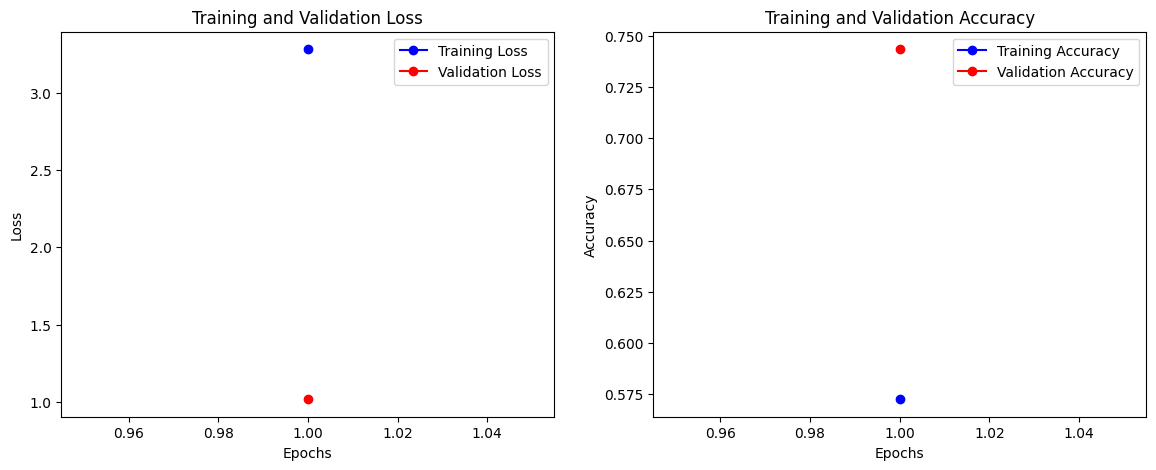

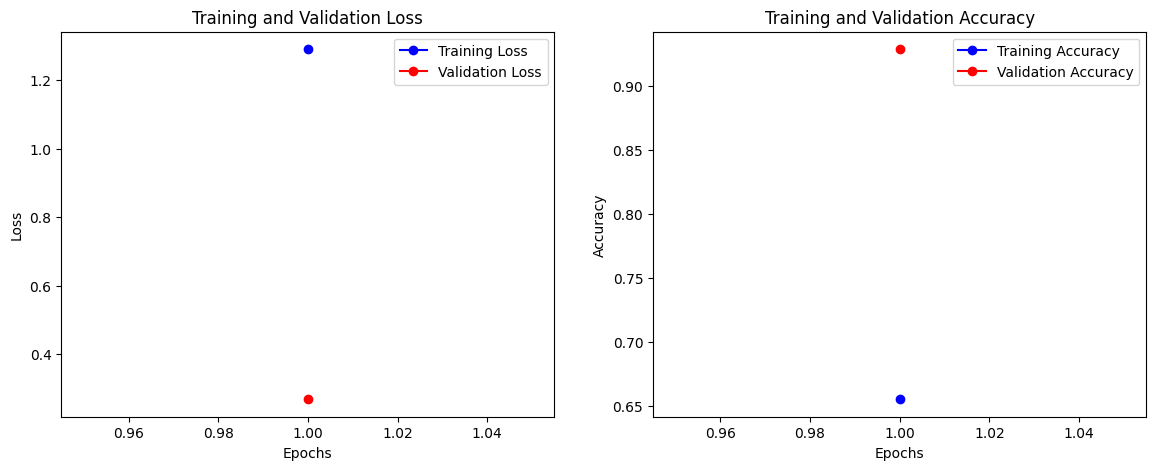

In [18]:
for history in [history_mlp, history_cnn]:
    # Extracting loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(14, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()